In [25]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import matplotlib.pyplot as plt

In [33]:
np.random.seed(1)  # for reproducibility


# def generate_data(N=80):
#     X = np.random.rand(N)[:, None] * 10 - 5  # Inputs, shape N x 1
#     F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
#     NoiseVar = 2 * np.exp(-((X - 2) ** 2) / 4) + 0.3  # Noise variances
#     Y = F + np.random.randn(N, 1) * np.sqrt(NoiseVar)  # Noisy data
#     return X, Y, NoiseVar


def generate_data(N=80):
#     X = np.random.rand(N)[:, None] * 10 - 5  # Inputs, shape N x 1
    
    X = np.linspace(-5, 5, N)[:, np.newaxis]
    
#     F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    
    F = X**2
    
    
    NoiseVar = 50 * 2 * np.exp(-((X - 2) ** 2) / 4) + 0.3  # Noise variances
#     Y = F + np.random.randn(N, 1) * np.sqrt(NoiseVar)  # Noisy data
    Y = F 
    return X, Y, NoiseVar



X, Y, NoiseVar = generate_data()

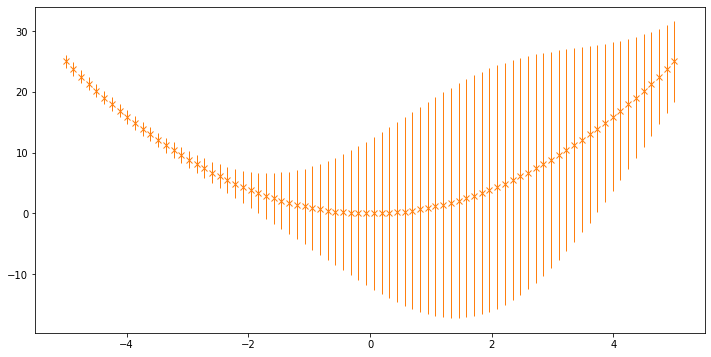

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
_ = ax.errorbar(
    X.squeeze(),
    Y.squeeze(),
    yerr=2 * (np.sqrt(NoiseVar)).squeeze(),
    marker="x",
    lw=0,
    elinewidth=1.0,
    color="C1",
)

In [35]:
Y_data = np.hstack([Y, NoiseVar])

In [36]:
class HeteroskedasticGaussian(gpflow.likelihoods.Likelihood):
    def __init__(self, **kwargs):
        # this likelihood expects a single latent function F, and two columns in the data matrix Y:
        super().__init__(latent_dim=1, observation_dim=2, **kwargs)

    def _log_prob(self, F, Y):
        # log_prob is used by the quadrature fallback of variational_expectations and predict_log_density.
        # Because variational_expectations is implemented analytically below, this is not actually needed,
        # but is included for pedagogical purposes.
        # Note that currently relying on the quadrature would fail due to https://github.com/GPflow/GPflow/issues/966
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        return gpflow.logdensities.gaussian(Y, F, NoiseVar)

    def _variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        Fmu, Fvar = Fmu[:, 0], Fvar[:, 0]
        return (
            -0.5 * np.log(2 * np.pi)
            - 0.5 * tf.math.log(NoiseVar)
            - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar
        )

    # The following two methods are abstract in the base class.
    # They need to be implemented even if not used.

    def _predict_log_density(self, Fmu, Fvar, Y):
        raise NotImplementedError

    def _predict_mean_and_var(self, Fmu, Fvar):
        raise NotImplementedError

In [37]:
# model construction
likelihood = HeteroskedasticGaussian()
kernel = gpflow.kernels.Matern52(lengthscales=0.5)
model = gpflow.models.VGP((X, Y_data), kernel=kernel, likelihood=likelihood, num_latent_gps=1)

In [38]:
natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam()

set_trainable(model.q_mu, False)
set_trainable(model.q_sqrt, False)

for _ in range(ci_niter(1000)):
    natgrad.minimize(model.training_loss, [(model.q_mu, model.q_sqrt)])
    adam.minimize(model.training_loss, model.trainable_variables)

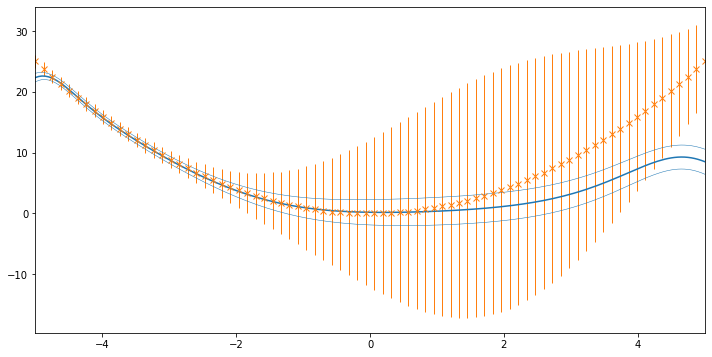

In [39]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

plt.figure(figsize=(12, 6))
plt.plot(xx, mu, "C0")
plt.plot(xx, mu + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(xx, mu - 2 * np.sqrt(var), "C0", lw=0.5)

plt.errorbar(
    X.squeeze(),
    Y.squeeze(),
    yerr=2 * (np.sqrt(NoiseVar)).squeeze(),
    marker="x",
    lw=0,
    elinewidth=1.0,
    color="C1",
)
_ = plt.xlim(-5, 5)